In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

jax.config.update("jax_enable_x64", True)
%matplotlib inline

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

# On Martini set the visible GPU to the 2080Ti
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Synthetic Data

In [2]:
# Kholodenko 2000
K_2000_idata, K_2000_ss, K_2000_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_smc_samples.json', sample_time=True)
K_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')
# Levchenko 2000
L_2000_idata, L_2000_ss, L_2000_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_smc_samples.json', sample_time=True)
L_2000_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss, HK_2003_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json', sample_time=True)
HK_2003_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
H_2005_idata, H_2005_ss, H_2005_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_smc_samples.json', sample_time=True)
H_2005_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
B_2007_idata, B_2007_ss, B_2007_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_smc_samples.json', sample_time=True)
B_2007_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss, O_2009_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_smc_samples.json', sample_time=True) 
O_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
vK_2009_idata, VK_2009_ss, VK_2009_sampleTime = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_smc_samples.json', sample_time=True)
vK_2009_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/vonKriegsheim_2009/vonKriegsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss, S_2014_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_smc_samples.json', sample_time=True)
S_2014_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss, R_2015_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_smc_samples.json', sample_time=True)
R_2015_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss, K_2017_sample_time = load_smc_samples_to_idata('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json', sample_time=True) 
K_2017_post = np.load('../../../results/MAPK/param_est/HF96_synthetic_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','hornberg_2005', 'birtwistle_2007', 'orton_2009', 'vonKriegsheim_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Hornberg 2005', 'Birtwistle 2007', 'Orton 2009', 'von Kriegsheim 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']

# gather posterior samples
posterior_samples = [K_2000_post, L_2000_post, HK_2003_post, H_2005_post, B_2007_post, O_2009_post, vK_2009_post, S_2014_post, R_2015_post, K_2017_post]
idata = [K_2000_idata, L_2000_idata, HK_2003_idata, H_2005_idata, B_2007_idata, O_2009_idata, vK_2009_idata, S_2014_idata, R_2015_idata, K_2017_idata]

shin_id = 7
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest green
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

Print sampling times for each model

In [3]:
print('kholodenko_2000:', K_2000_sample_time/3600, 'hr')
print('levchenko_2000:', L_2000_sample_time/3600, 'hr')
print('hatakeyama_2003:', HK_2003_sample_time/3600, 'hr')
print('hornberg_2005:', H_2005_sample_time/3600, 'hr')
print('birtwistle_2007:', B_2007_sample_time/3600, 'hr')
print('orton_2009:', O_2009_sample_time/3600, 'hr')
print('vonKriegsheim_2009', VK_2009_sampleTime/3600, 'hr')
print('shin_2014:', S_2014_sample_time/3600, 'hr')
print('ryu_2015:', R_2015_sample_time/3600, 'hr')
print('kochanczyk_2017:', K_2017_sample_time/3600, 'hr')


kholodenko_2000: 0.7210288670990203 hr
levchenko_2000: 21.150731351971626 hr
hatakeyama_2003: 7.0091702158583535 hr
hornberg_2005: 104.23303360773457 hr
birtwistle_2007: 9.563757076395882 hr
orton_2009: 5.5261511445045475 hr
vonKriegsheim_2009 1223.4317882341809 hr
shin_2014: 0.1840419853395886 hr
ryu_2015: 3.4326902950472302 hr
kochanczyk_2017: 67.4421711036894 hr


## Make posterior predictive dose responses in a more compact form

plotting kholodenko_2000
plotting levchenko_2000
plotting hatakeyama_2003
plotting hornberg_2005
plotting birtwistle_2007
plotting orton_2009
plotting vonKriegsheim_2009
plotting shin_2014
plotting ryu_2015
plotting kochanczyk_2017


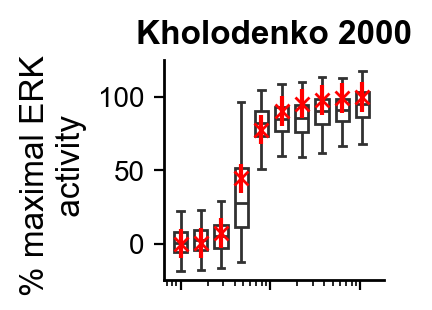

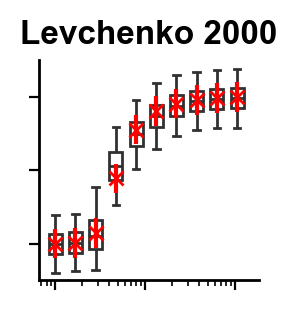

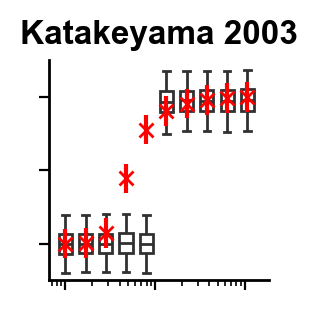

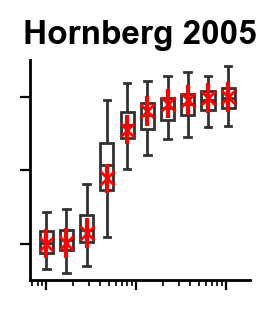

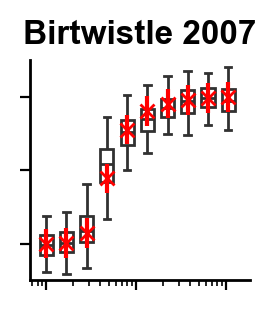

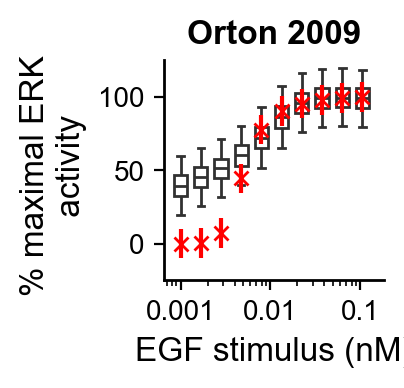

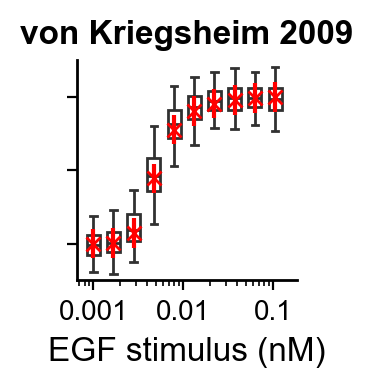

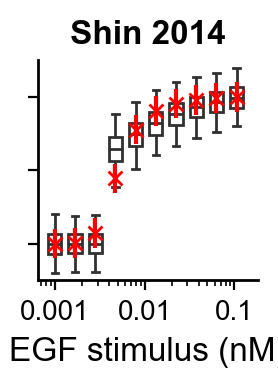

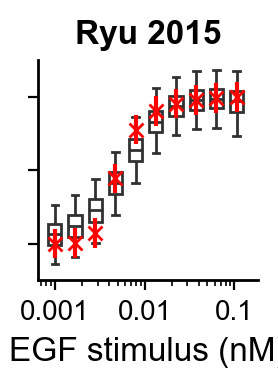

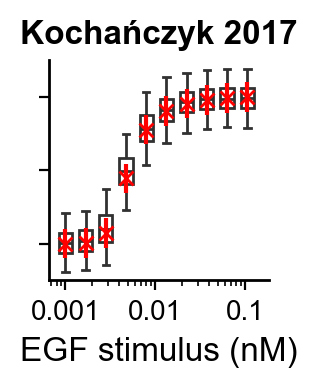

In [4]:
plotting_params = {
    'kholodenko_2000':[False,False,True,True],'levchenko_2000':[False,False,False,False],'hatakeyama_2003':[False,False,False,False],'hornberg_2005':[False,False,False,False],'birtwistle_2007':[False,False,False,False],'orton_2009':[True,True,True,True],'vonKriegsheim_2009':[True,True,False,False],'shin_2014':[True,True,False,False],'ryu_2015':[True,True,False,False],'kochanczyk_2017':[True,True,False,False]
}

# skip_idxs = [0,1,2,3,4,5,7,8,9]
skip_idxs = []
for idx,model in enumerate(model_names):
    if idx in skip_idxs:
        print('skipping', model)
        continue
    else:
        print('plotting', model)

        plot_p = plotting_params[model]

        fig, ax = plot_stimulus_response_curve(posterior_samples[idx], data, inputs, input_name='EGF stimulus (nM)', output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                        data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0,
                                        title=display_names[idx], xlabel=plot_p[0],xticklabels=plot_p[1],ylabel=plot_p[2], yticklabels=plot_p[3])
        ax.set_title(ax.get_title(), fontsize=12.0)
        fig.savefig('../../../results/MAPK/param_est/HF96_synthetic_data/'+model+'/'+model+'_posterior_predictive.pdf', transparent=True)

# plt.close('all')

## We also need to plot and analyze dose responses that are not posterior predictive, but simply use posterior samples to compute the dose response

In [5]:
model_info = json.load(open('model_info.json', 'r'))

plotting_params = {
    'kholodenko_2000':[False,False,True,True],'levchenko_2000':[False,False,False,False],'hatakeyama_2003':[False,False,False,False],'hornberg_2005':[False,False,False,False],'birtwistle_2007':[False,False,False,False],'orton_2009':[True,True,True,True],'vonKriegsheim_2009':[True,True,False,False],'shin_2014':[True,True,False,False],'ryu_2015':[True,True,False,False],'kochanczyk_2017':[True,True,False,False]
}

skip_idxs = [0,1,2,6]
for idx,model in enumerate(model_info.keys()):
    if idx in skip_idxs:
        print('skipping', model)
        continue
    else:
        print('plotting', model)
        this_model_info = model_info[model]

        plot_p = plotting_params[model]

        # create dose-response curve prediction
        dose_response = predict_dose_response(model, idata[idx], inputs,   
                                this_model_info['input_state'], this_model_info['ERK_states'], 
                                float(this_model_info['max_time']), EGF_conversion_factor=float(this_model_info['EGF_conversion_factor']),nsamples=400)
        # save
        np.save('../../../results/MAPK/param_est/HF96_synthetic_data/'+model+'/dose_response_predict.npy', dose_response)

        fig, ax = plot_stimulus_response_curve(dose_response, data, inputs, input_name='EGF stimulus (nM)', output_name='% maximal ERK \n activity', box_color='w', data_color=orange,
                                        data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0,
                                        title=this_model_info['display_name'], xlabel=plot_p[0],xticklabels=plot_p[1],ylabel=plot_p[2], yticklabels=plot_p[3])
        ax.set_title(ax.get_title(), fontsize=12.0)
        fig.savefig('../../../results/MAPK/param_est/HF96_synthetic_data/'+model+'/dose_response_predict.pdf', transparent=True)


skipping kholodenko_2000
skipping levchenko_2000
skipping hatakeyama_2003
plotting hornberg_2005


100%|██████████| 400/400 [1:29:04<00:00, 13.36s/it]


plotting birtwistle_2007


100%|██████████| 400/400 [25:17<00:00,  3.79s/it]


plotting orton_2009


100%|██████████| 400/400 [00:23<00:00, 16.97it/s]


skipping vonKriegsheim_2009
plotting shin_2014


100%|██████████| 400/400 [00:03<00:00, 132.91it/s]


plotting ryu_2015


100%|██████████| 400/400 [00:09<00:00, 40.35it/s]


plotting kochanczyk_2017


 33%|███▎      | 131/400 [1:39:40<2:29:42, 33.39s/it]  

### Generate trajectories for each model
We need to normalize these to some model-specific maximum. For this we will use the max value over all trajectories for each model

In [ ]:
model_info = json.load(open('model_info.json', 'r'))

plotting_params = {
    'kholodenko_2000':[False,False,True,True],'levchenko_2000':[False,False,False,False],'hatakeyama_2003':[False,False,False,False],'hornberg_2005':[False,False,False,False],'birtwistle_2007':[False,False,False,False],'orton_2009':[True,True,True,True],'vonKriegsheim_2009':[True,True,False,False],'shin_2014':[True,True,False,False],'ryu_2015':[True,True,False,False],'kochanczyk_2017':[True,True,False,False]
}

n_traj = 400

skip_idxs = []
for idx,model in enumerate(model_info.keys()):
    if idx in skip_idxs:
        print('skipping', model)
        continue
    else:
        print('plotting', model)
        this_model_info = model_info[model]

        plot_p = plotting_params[model]

     
        # predict trajectories
        traj = predict_traj_response(model, idata[idx], inputs_traj, times_traj, 
                                              this_model_info['input_state'], this_model_info['ERK_states'],
                                              float(this_model_info['time_conversion']),
                                              EGF_conversion_factor=float(this_model_info['EGF_conversion_factor']),
                                              nsamples=400)
        # save
        np.save('../../../results/MAPK/param_est/HF96_synthetic_data/'+model+'/traj_predict.npy', dose_response)

        # plot
        plot_posterior_trajectories(traj, data_traj, data_std_traj, times_traj, colors[idx], 
                                        inputs, '../../../results/MAPK/param_est/HF96_synthetic_data/'+model+'/',
                                        model, data_time_to_mins=60,
                                        width=1.1, height=0.5, 
                                        data_downsample=10,
                                        ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                        y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                        fname='_pred_traj_')
plt.close('all')